In [1]:
# All imports should be in first cell
import cartopy
import GMesh
import importlib
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

# GridMesh Class

Class is defined in file **GMesh.py**. `imp.reload(GMesh)` reloads the module if changed during development.

In [2]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
importlib.reload(GMesh)

help(GMesh)

Help on module GMesh:

NAME
    GMesh

CLASSES
    builtins.object
        GMesh
    
    class GMesh(builtins.object)
     |  GMesh(shape=None, lon=None, lat=None, area=None, lon0=-180.0, from_cell_center=False, rfl=0)
     |  
     |  Describes 2D meshes for ESMs.
     |  
     |  Meshes have shape=(nj,ni) cells with (nj+1,ni+1) vertices with coordinates (lon,lat).
     |  
     |  When constructing, either provide 1d or 2d coordinates (lon,lat), or assume a
     |  uniform spherical grid with 'shape' cells covering the whole sphere with
     |  longitudes starting at lon0.
     |  
     |  Attributes:
     |  
     |  shape - (nj,ni)
     |  ni    - number of cells in i-direction (last)
     |  nj    - number of cells in j-direction (first)
     |  lon   - longitude of mesh (cell corners), shape (nj+1,ni=1)
     |  lat   - latitude of mesh (cell corners), shape (nj+1,ni=1)
     |  area  - area of cells, shape (nj,ni)
     |  
     |  Methods defined here:
     |  
     |  __copy__(s

# Create a target grid

This creates a regular spherical (geographic) grid covering the Mediterranean between 7$^\circ$W and 42$^\circ$E, 30$^\circ$N and 48$^\circ$N, with 1$^\circ$ spacing in both directions.

<GMesh nj:18 ni:49 shape:(18,49)>


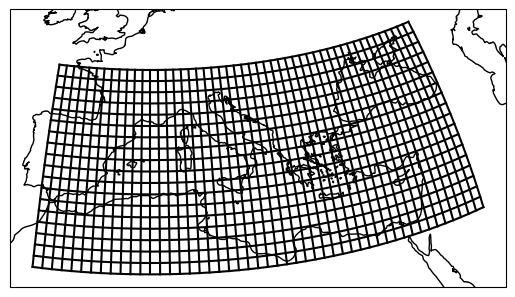

In [3]:
target_mesh = GMesh.GMesh( lon=np.linspace(-7, 42, 50), lat=np.linspace(30, 48, 19) )
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=5, central_latitude=36))
ax.coastlines()
target_mesh.plot(ax, transform=cartopy.crs.Geodetic())
print( target_mesh )

# Open and read a topographic dataset

Open a topography dataset, check that the topography is on a uniform grid.

In [4]:
# URL of topographic data, names of longitude, latitude and elevation variables
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lon = np.array( topo_data.variables[vx][:] )
topo_lat = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lon, topo_lat ) )

topography grid array shapes:  (86400,) (43200,)
topography longitude range: -179.99791666666667 179.99791666666667
topography latitude range: -89.99791666666667 89.99791666666667
Is mesh uniform? True


Find indexes of "mesh" within topographic dataset. Create python "slices" to use to extract relevant topography.

In [5]:
# Indices in topographic data
ti,tj = target_mesh.find_nn_uniform_source( topo_lon, topo_lat )
tis,tjs = slice(ti.min(), ti.max(),5), slice(tj.min(), tj.max(),5)
print('Slices:', tis, tjs )

Slices: slice(41639, 53160, 5) slice(28920, 33000, 5)


Extract and plot topography (subsampled by 5), overlay mesh

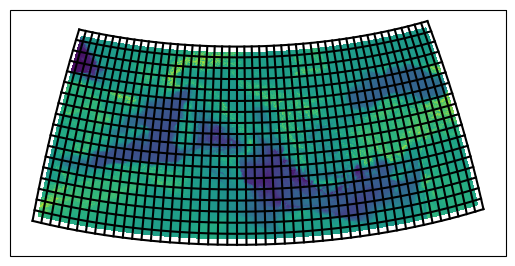

In [6]:
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=15, central_latitude=36))
topo_elv = topo_data.variables[ve][tjs,tis]
ax.pcolormesh( topo_lon[tis], topo_lat[tjs], topo_elv, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax, transform=cartopy.crs.Geodetic())